In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import scoring_utils

In [46]:
df = pd.read_csv('../data/data_clean.csv')

df.head(1)

,City,State,Bank,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,GrAppv,SBA_Appv,Default,NAICS_i,isNewBusiness,isFranchise,SBARatio,InterestRate
0,EVANSVILLE,IN,FIFTH THIRD BANK,1997,84,4,0,0,1,0,0,1,60000.0,48000.0,0,45,1.0,0,0.8,5.19


In [47]:
# one-hot encode UrbanRural and include it
from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(sparse_output=False,handle_unknown='ignore')

UR_encoded = OHE.fit_transform(df[['UrbanRural']])
UR_enc_df = pd.DataFrame(UR_encoded,columns = OHE.get_feature_names_out(['UrbanRural']))
df = pd.concat([df,UR_enc_df], axis=1)
df.drop(columns=['UrbanRural'], inplace=True)


In [48]:
# Select Features (X) and Target (Y)
#X = df[['ApprovalFY','Term','NoEmp','CreateJob','RetainedJob','FranchiseCode','UrbanRural','RevLineCr','LowDoc','GrAppv','SBA_Appv','NAICS_i','isNewBusiness','isFranchise','SBARatio','InterestRate']]
experimental_features = ['City', 'State', 'Bank', 'ApprovalFY', 'NAICS_i', 'FranchiseCode']

features = [f for f in df.columns if f not in experimental_features]

X = df[features]
Y = df['Default']

In [49]:
# Do a train-test split
X_train, X_tmp, y_train, y_tmp = train_test_split(X,Y,test_size=0.2,random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_tmp, y_tmp, test_size=.5)



In [56]:
# Scale Features
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_cv_scaled = sc.transform(X_cv)
X_test_scaled = sc.transform(X_test)
X_scaled =sc.transform(X)

In [51]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [52]:
coefficients = model.coef_[0]
feature_names = X.columns

coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

print(coef_df)

          Feature  Coefficient
0            Term    -0.518469
1           NoEmp    -0.014348
2       CreateJob     0.018500
3     RetainedJob     0.009187
4       RevLineCr    -0.042610
5          LowDoc    -0.116132
6          GrAppv     0.044533
7        SBA_Appv    -0.020517
8         Default     8.403887
9   isNewBusiness     0.025221
10    isFranchise     0.004926
11       SBARatio     0.005427
12   InterestRate     0.178075
13   UrbanRural_0    -0.172302
14   UrbanRural_1     0.132559
15   UrbanRural_2     0.051569


In [53]:
#make predictions
yhat_train = model.predict(X_train_scaled)
yhat_cv = model.predict(X_test_scaled)

score = pd.concat([
    scoring_utils.get_metrics(y_train, yhat_train, "Logit Train"),
    scoring_utils.get_metrics(y_test, yhat_cv, "Logit CV")
])

score

,Recall,Precision,ROC,F1
Logit Train,1.0,1.0,1.0,1.0
Logit CV,1.0,1.0,1.0,1.0


In [54]:
model.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

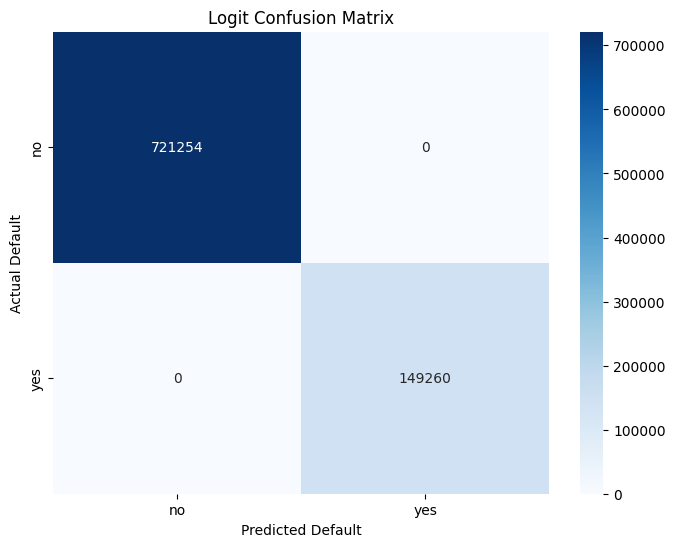

In [58]:
yhat_total = model.predict(X_scaled)
scoring_utils.get_confusion_matrix(Y, yhat_total, "Logit")

In [59]:
scoring_utils.get_profit(X, Y, yhat_total)

7576088053.8